In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import math
import numpy as np

def f(x):
    return x**2 - 2*x + 4

xs = np.arange(-10, 10, 0.25)
ys = f(xs)
ys


array([124.    , 118.5625, 113.25  , 108.0625, 103.    ,  98.0625,
        93.25  ,  88.5625,  84.    ,  79.5625,  75.25  ,  71.0625,
        67.    ,  63.0625,  59.25  ,  55.5625,  52.    ,  48.5625,
        45.25  ,  42.0625,  39.    ,  36.0625,  33.25  ,  30.5625,
        28.    ,  25.5625,  23.25  ,  21.0625,  19.    ,  17.0625,
        15.25  ,  13.5625,  12.    ,  10.5625,   9.25  ,   8.0625,
         7.    ,   6.0625,   5.25  ,   4.5625,   4.    ,   3.5625,
         3.25  ,   3.0625,   3.    ,   3.0625,   3.25  ,   3.5625,
         4.    ,   4.5625,   5.25  ,   6.0625,   7.    ,   8.0625,
         9.25  ,  10.5625,  12.    ,  13.5625,  15.25  ,  17.0625,
        19.    ,  21.0625,  23.25  ,  25.5625,  28.    ,  30.5625,
        33.25  ,  36.0625,  39.    ,  42.0625,  45.25  ,  48.5625,
        52.    ,  55.5625,  59.25  ,  63.0625,  67.    ,  71.0625,
        75.25  ,  79.5625])

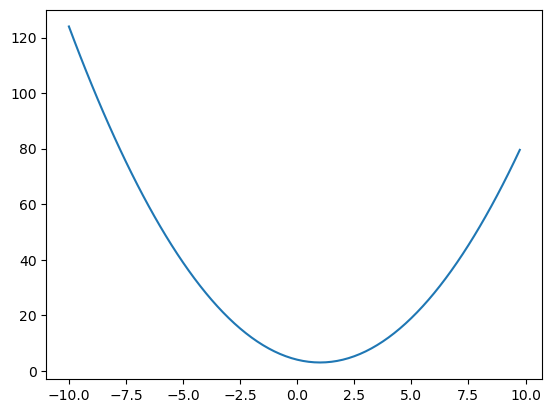

In [3]:
plt.plot(xs,ys)

In [28]:
class Value:
    def __init__(self,data,_children=(),_op='',label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda:None        
        self.grad = 0.0
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data,(self,other),'+')
        
        def _backward():
#             when addition operation gradient gets distributed
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data,(self,other),'*')
        def _backward():
#           when addition operation gradient gets distributed
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(exp(x),(self,),'exp')
        
        def _backward():
            self.grad  += out.data * out.grad
            
        out._backward = _backward
        return out
    
    def __rmul__(self,other):
        return self * other
    
    def __truediv__(self,other):
        return self * other ** -1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float));
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward
        
    def __neg__(self): 
        return self * -1

    def __radd__(self, other): 
        return self + other

    def __sub__(self, other): 
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self,),'tanh')
        
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        visited = set()
        topo = []
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                todo.append(v)
        build_top(self)
        
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()
            

In [30]:
a = Value(2.0)
a  - 1

Value(data=1.0)

In [6]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    print(root)
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f  }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
      # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
          dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
    # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [52]:

class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self,x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out = act.tanh()
            
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters() ]
            

class MLP:
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))] 
        
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
            
            
    


In [53]:
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])

n(x)
    

Value(data=-0.551089433016079)

Value(data=-0.551089433016079)


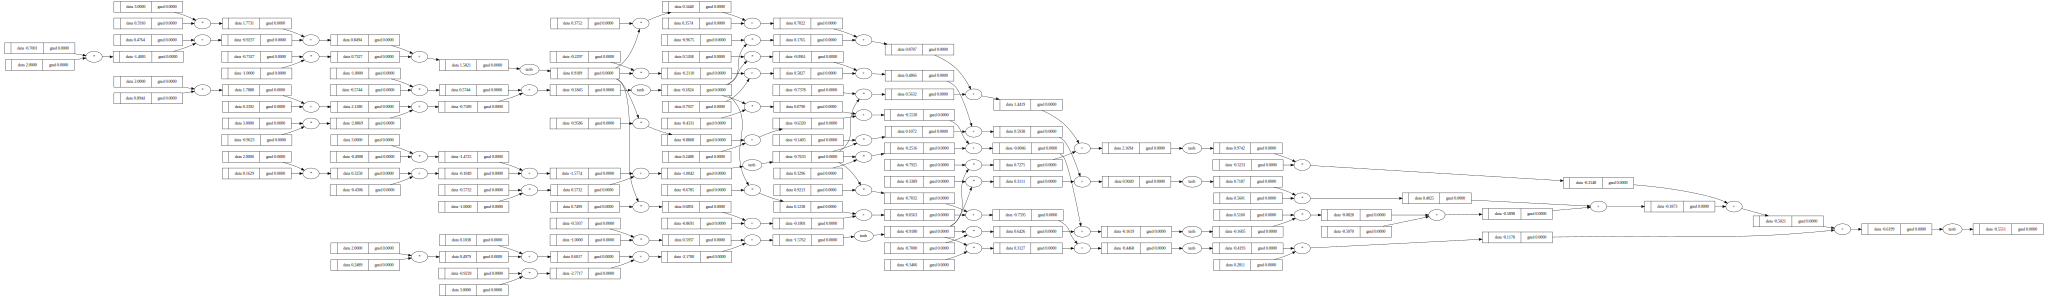

In [54]:
draw_dot(n(x))

In [55]:

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]; 


In [60]:
for k in range(20):
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt))**2 for ygt, yout in zip(ys, ypred))
    
    for p in n.parameters():
        p.grad  = 0.0
    
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.01*p.grad
        
    print(k,loss.data)


0 5.604503604852852e-05
1 5.601284055322995e-05
2 5.598068567984163e-05
3 5.594857135027531e-05
4 5.5916497486635245e-05
5 5.588446401122578e-05
6 5.585247084656011e-05
7 5.5820517915339546e-05
8 5.578860514047752e-05
9 5.5756732445078675e-05
10 5.5724899752440404e-05
11 5.569310698606945e-05
12 5.566135406965494e-05
13 5.5629640927092e-05
14 5.559796748246793e-05
15 5.5566333660063117e-05
16 5.55347393843514e-05
17 5.5503184580006756e-05
18 5.5471669171883275e-05
19 5.5440193085039186e-05


In [61]:
ypred

[Value(data=0.9989157415346523),
 Value(data=-0.9927126884247788),
 Value(data=-0.9999987632883723),
 Value(data=0.9989231225039252)]